In [1]:
library(ggplot2)
library(dplyr)
library(glue)
library(gridExtra)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [2]:
output = read.table("~/CondPCA/ASHG/output.txt",header=TRUE)
output = output %>% distinct()
output[is.na(output$flag),]$flag = "7_cts"
state_type = unique(output$state_type)
num_cells = unique(output$flag)
head(output)
dim(output)

,seed,method,state_type,dim,total_cells,perc_genes,perc_cells,flag,ct_in_state,adj.rsq,max.rsq,max.rsq_sub,total_cells_can_occupy_state,total_cells_occupy_state,total_genes,total_genes_in_state
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,5,PCA,within_one_ct,10,20000,0.15,0.3,7_cts,EX,0.2217110,0.10375358,0.049929683,2001,600,2527,379
2,8,PCA,within_one_ct,10,20000,0.15,0.3,7_cts,MG,0.2379077,0.12935458,0.006875595,1292,387,2527,379
3,6,PCA,within_one_ct,10,20000,0.15,0.3,7_cts,ODC,0.1123940,0.08348754,0.002228151,12220,3666,2527,379
4,6,PCA,within_one_ct,10,20000,0.15,0.7,7_cts,ODC,0.3491209,0.25840651,0.005449603,12220,8554,2527,379
5,2,PCA,within_one_ct,10,20000,0.15,0.5,7_cts,ODC,0.2161818,0.16002318,0.002795771,12220,6110,2527,379
6,9,PCA,within_one_ct,10,20000,0.15,0.7,7_cts,INH,0.5483137,0.28332267,0.012073433,1939,1357,2527,379


[1] 2341   16

In [3]:
tmp_df <- na.omit(output)

sd = tmp_df %>% group_by(method,state_type,dim, total_cells, flag, perc_genes, perc_cells) %>% 
                      summarise(across(c(adj.rsq,max.rsq,max.rsq_sub),sd),
                    .groups = 'drop') %>%
                      as.data.frame()


counts = tmp_df %>% group_by(method,state_type,dim, total_cells, flag, perc_genes, perc_cells) %>% 
                      summarise(n = n())%>%
                      as.data.frame()

colnames(sd)[(length(colnames(sd))-2) : length(colnames(sd)) ] = paste0("sd","_", colnames(sd)[(length(colnames(sd))-2) : length(colnames(sd)) ] )


mean = tmp_df %>% group_by(method,state_type,dim, total_cells, flag, perc_genes, perc_cells) %>% 
                      summarise(across(c(adj.rsq,max.rsq,max.rsq_sub),mean),
                    .groups = 'drop') %>%
                      as.data.frame()

all_merged = merge(mean, merge(sd,counts,by=colnames(sd)[1:7]), by=colnames(sd)[1:7] )
all_merged$conf_int_max.rsq_sub = all_merged$sd_max.rsq_sub / sqrt(all_merged$n) * qnorm(0.975)
all_merged$perc_genes_perc_cells = paste(all_merged$perc_genes, all_merged$perc_cells, sep=", ")

`summarise()` has grouped output by 'method', 'state_type', 'dim',
'total_cells', 'flag', 'perc_genes'. You can override using the `.groups`
argument.


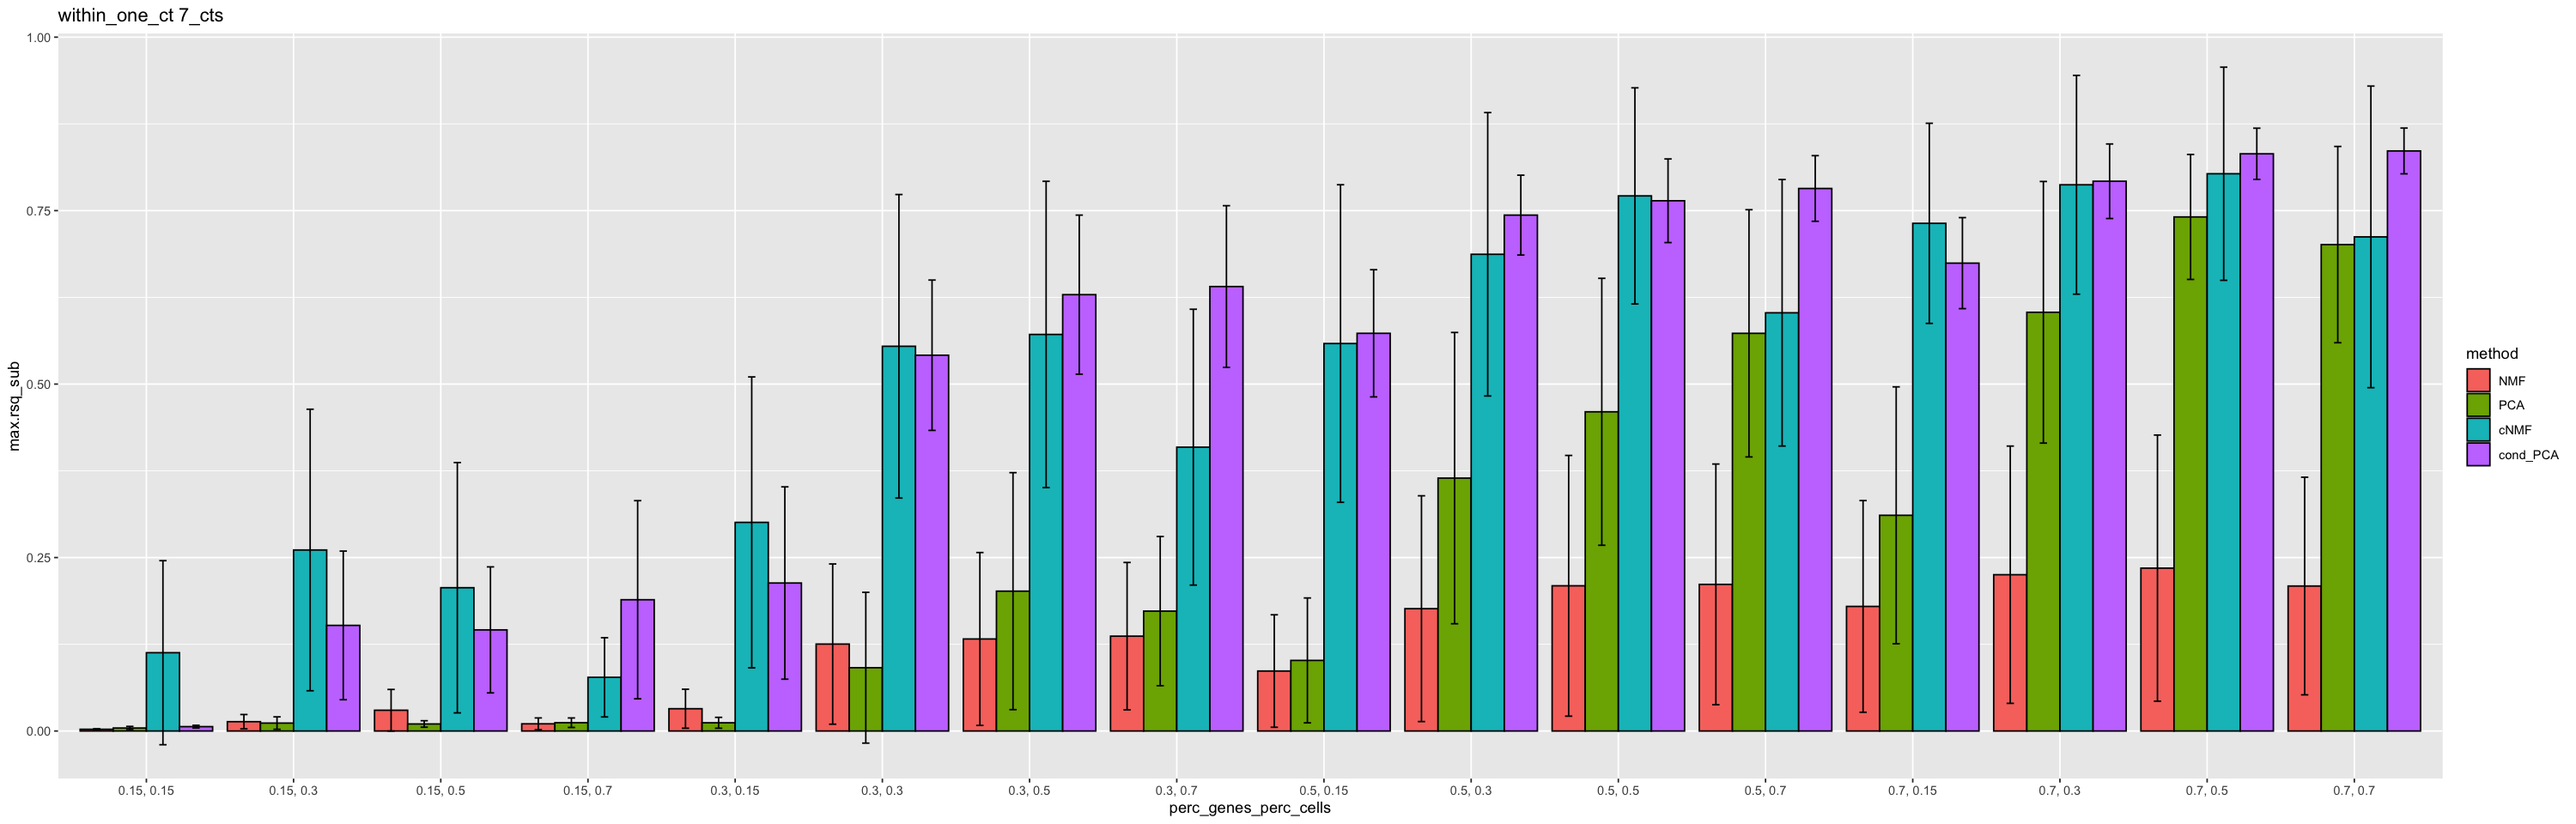

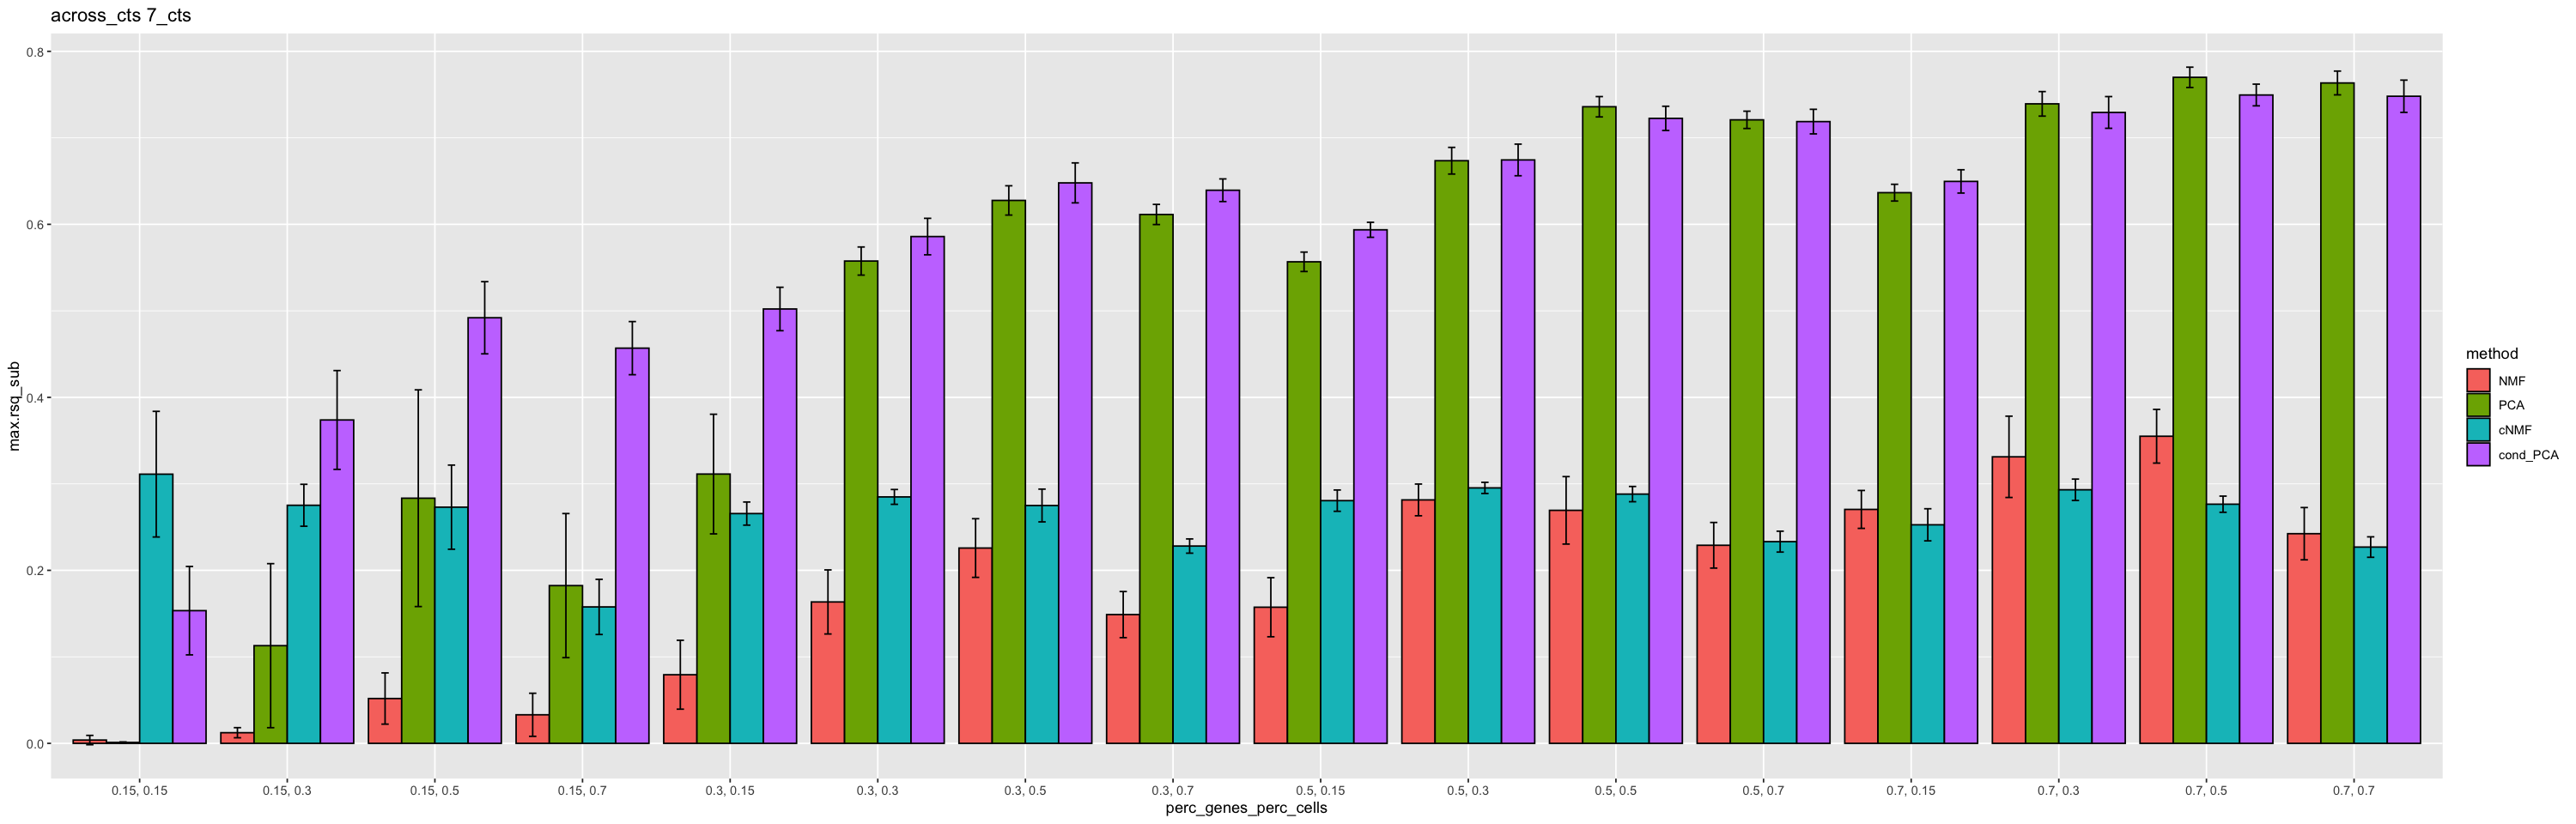

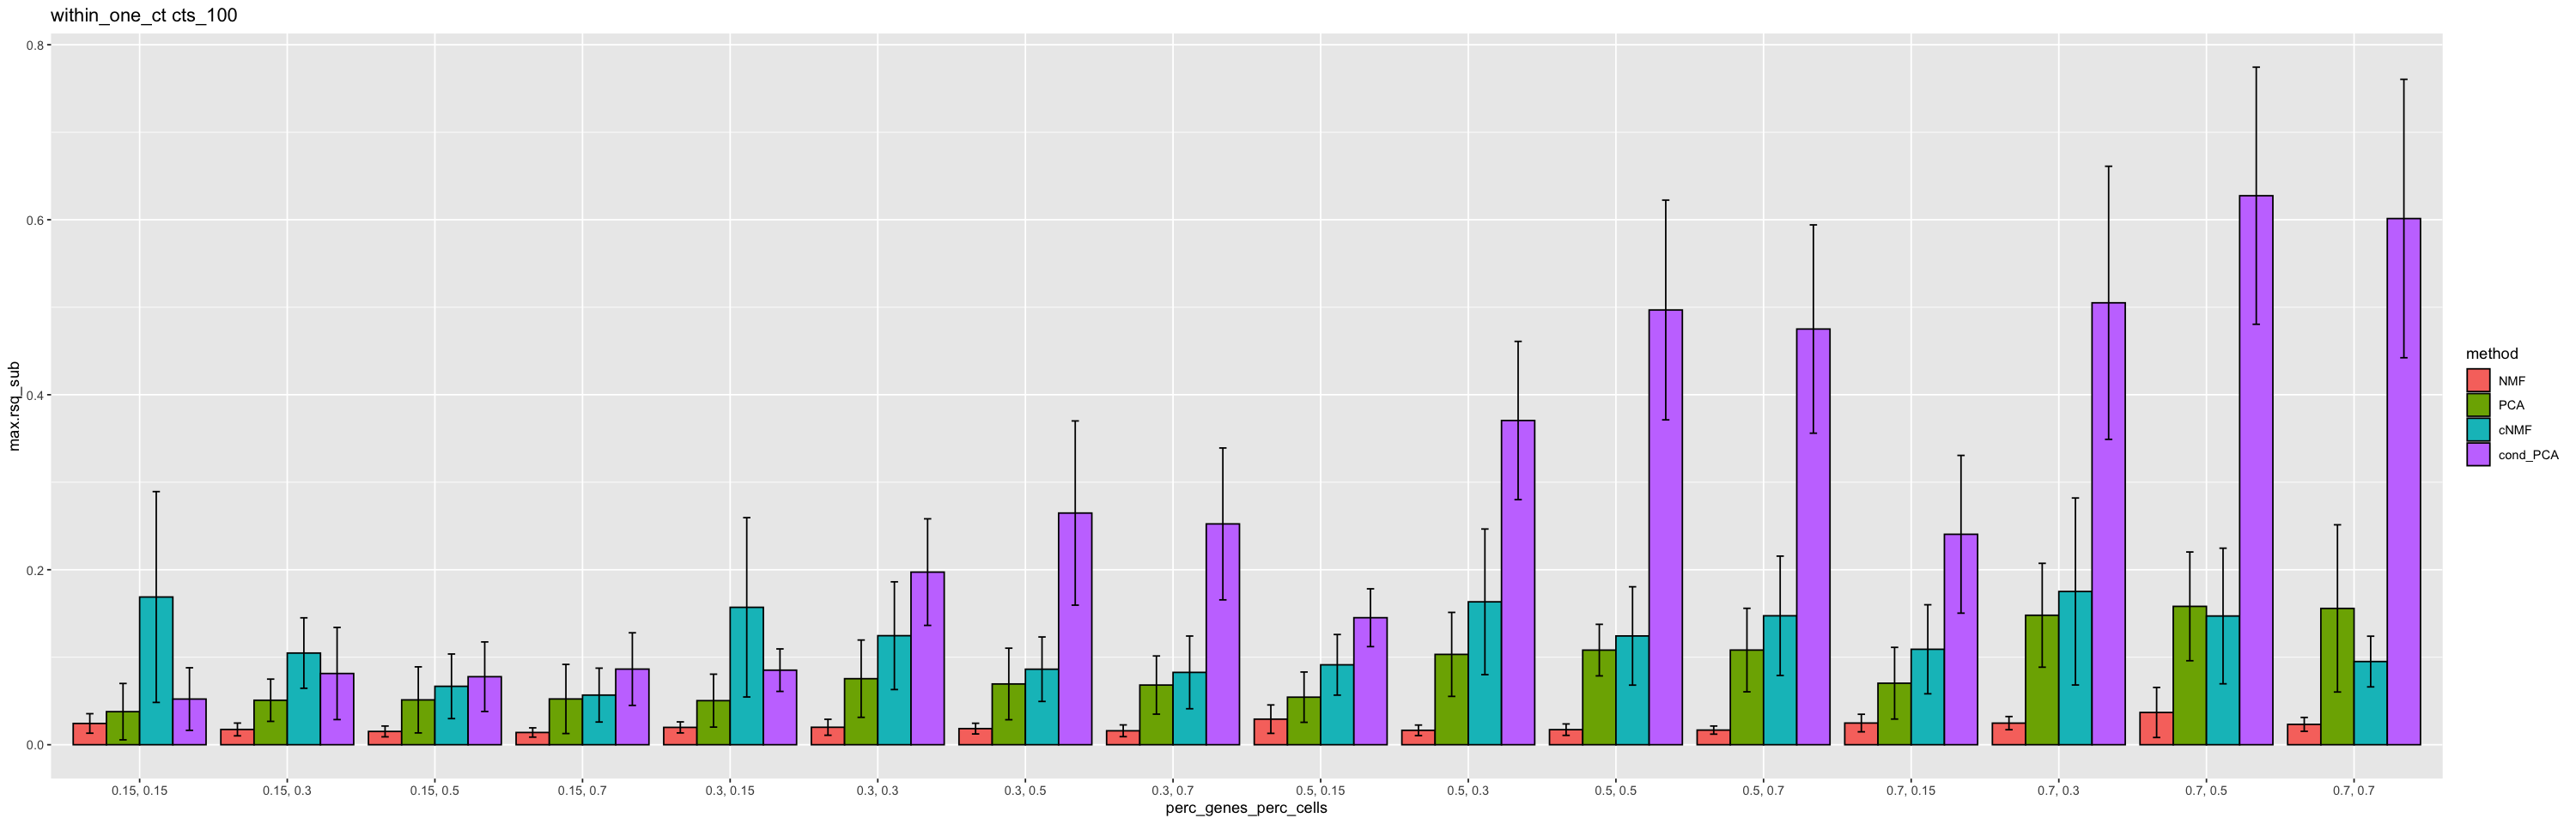

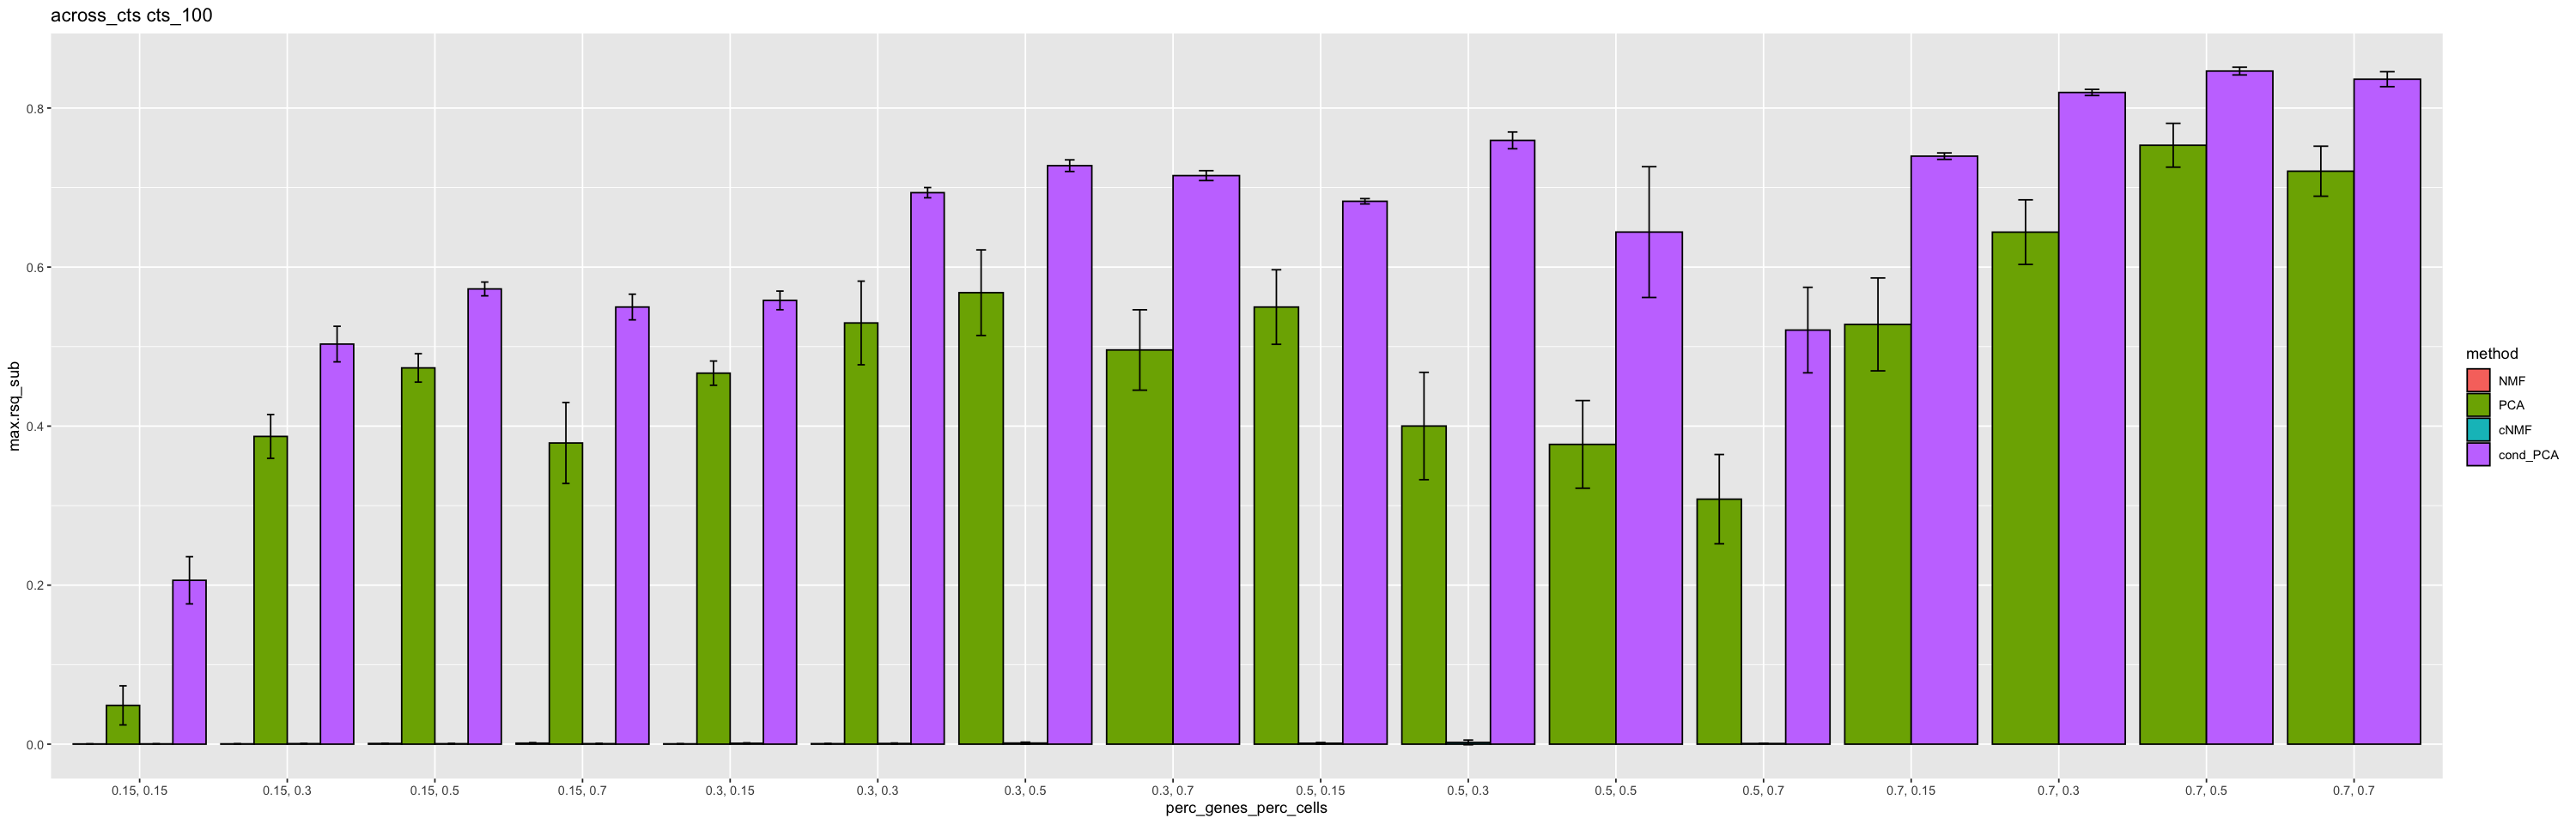

In [4]:
options(repr.plot.width=10, repr.plot.height=8)

num_cells = c("7_cts","cts_100")

for (num_cells_ in num_cells){
    for (state_type_ in state_type){
    
        options(repr.plot.width=25, repr.plot.height=8)
        #all_merged
        
        tmp_df = all_merged[all_merged$state_type == state_type_ & all_merged$flag == num_cells_,]

        # plot where perc genes equals perc cells
        p = ggplot(data=tmp_df, aes(x=perc_genes_perc_cells, y=max.rsq_sub, fill=method)) +
         geom_bar(stat="identity", color="black", position=position_dodge()) +
  geom_errorbar(aes(ymin=max.rsq_sub-conf_int_max.rsq_sub, ymax=max.rsq_sub+conf_int_max.rsq_sub), width=.2,
                 position=position_dodge(.9)) + ggtitle(glue("{state_type_} {num_cells_}"))
        print(p)
    }
    
}

In [5]:
common = all_merged[all_merged$perc_genes_perc_cells == "0.7, 0.7",]
common$Freq = "Common"
common

,method,state_type,dim,total_cells,flag,perc_genes,perc_cells,adj.rsq,max.rsq,max.rsq_sub,sd_adj.rsq,sd_max.rsq,sd_max.rsq_sub,n,conf_int_max.rsq_sub,perc_genes_perc_cells,Freq
,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
16,NMF,across_cts,10,20000,7_cts,0.7,0.7,0.57647485,0.24238291,0.24238291,0.080286138,0.04874719,0.04874719,10,0.030213268,"0.7, 0.7",Common
38,NMF,within_one_ct,10,20000,7_cts,0.7,0.7,0.64012421,0.57464593,0.20896447,0.124408216,0.08840487,0.25302194,10,0.156821739,"0.7, 0.7",Common
54,NMF,within_one_ct,105,40000,cts_100,0.7,0.7,0.56663998,0.56645132,0.02328965,0.011282895,0.01057551,0.01214916,9,0.007937305,"0.7, 0.7",Common
70,PCA,across_cts,10,20000,7_cts,0.7,0.7,0.80760774,0.76343943,0.76343943,0.011920063,0.02217506,0.02217506,10,0.013743995,"0.7, 0.7",Common
86,PCA,across_cts,105,40000,cts_100,0.7,0.7,0.83428407,0.72060111,0.72060111,0.004194847,0.05075488,0.05075488,10,0.031457620,"0.7, 0.7",Common
102,PCA,within_one_ct,10,20000,7_cts,0.7,0.7,0.78396504,0.33910972,0.70105080,0.083333191,0.09437507,0.22820856,10,0.141442532,"0.7, 0.7",Common
118,PCA,within_one_ct,105,40000,cts_100,0.7,0.7,0.53405464,0.21654596,0.15580665,0.070866569,0.09007380,0.15417209,10,0.095555095,"0.7, 0.7",Common
134,cNMF,across_cts,10,20000,7_cts,0.7,0.7,0.82071980,0.22690502,0.22690502,0.015147655,0.01908218,0.01908218,10,0.011827042,"0.7, 0.7",Common
160,cNMF,within_one_ct,10,20000,7_cts,0.7,0.7,0.85075852,0.82156638,0.71216623,0.157445394,0.14613336,0.35067195,10,0.217344731,"0.7, 0.7",Common


In [6]:
across_7 = all_merged[all_merged$flag == "7_cts" & all_merged$state_type == "across_cts" & all_merged$perc_genes_perc_cells == "0.15, 0.7",]
across_7$Freq = "Rare"

across_100 = all_merged[all_merged$flag == "cts_100" & all_merged$state_type == "across_cts" & all_merged$perc_genes_perc_cells == "0.15, 0.7",]
across_100$Freq = "Rare"

within_7 = all_merged[all_merged$flag == "7_cts" & all_merged$state_type == "within_one_ct" & all_merged$perc_genes_perc_cells == "0.3, 0.7",]
within_7$Freq = "Rare"

within_100 = all_merged[all_merged$flag == "cts_100" & all_merged$state_type == "within_one_ct" & all_merged$perc_genes_perc_cells == "0.3, 0.5",]
within_100$Freq = "Rare"

In [7]:
all = rbind(across_7, within_7, across_100,within_100, common)
all

,method,state_type,dim,total_cells,flag,perc_genes,perc_cells,adj.rsq,max.rsq,max.rsq_sub,sd_adj.rsq,sd_max.rsq,sd_max.rsq_sub,n,conf_int_max.rsq_sub,perc_genes_perc_cells,Freq
,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
4,NMF,across_cts,10,20000,7_cts,0.15,0.7,0.056879827,0.0330134680,0.0330134680,0.057030412,0.0401768796,0.0401768796,10,0.0249014304,"0.15, 0.7",Rare
58,PCA,across_cts,10,20000,7_cts,0.15,0.7,0.220315771,0.1823569627,0.1823569627,0.152010285,0.1343960492,0.1343960492,10,0.0832980036,"0.15, 0.7",Rare
122,cNMF,across_cts,10,20000,7_cts,0.15,0.7,0.351254483,0.1577179759,0.1577179759,0.110357662,0.0514418116,0.0514418116,10,0.0318833793,"0.15, 0.7",Rare
180,cond_PCA,across_cts,10,20000,7_cts,0.15,0.7,0.465337293,0.4568740861,0.4568740861,0.046276220,0.0495782038,0.0495782038,10,0.0307283244,"0.15, 0.7",Rare
30,NMF,within_one_ct,10,20000,7_cts,0.30,0.7,0.568876505,0.5625497250,0.1367132902,0.029569661,0.0317997396,0.1713434769,10,0.1061978358,"0.3, 0.7",Rare
94,PCA,within_one_ct,10,20000,7_cts,0.30,0.7,0.554599573,0.2668870479,0.1728094025,0.068833601,0.0191091063,0.1734711147,10,0.1075165351,"0.3, 0.7",Rare
152,cNMF,within_one_ct,10,20000,7_cts,0.30,0.7,0.679048394,0.6532110297,0.4090745951,0.158157289,0.1873415466,0.3207598117,10,0.1988053379,"0.3, 0.7",Rare
216,cond_PCA,within_one_ct,10,20000,7_cts,0.30,0.7,0.240121611,0.2284337048,0.6405936039,0.108443289,0.1162022294,0.1880079695,10,0.1165264056,"0.3, 0.7",Rare
20,NMF,across_cts,105,40000,cts_100,0.15,0.7,0.004754796,0.0012803351,0.0012803351,0.002710916,0.0011064120,0.0011064120,10,0.0006857487,"0.15, 0.7",Rare


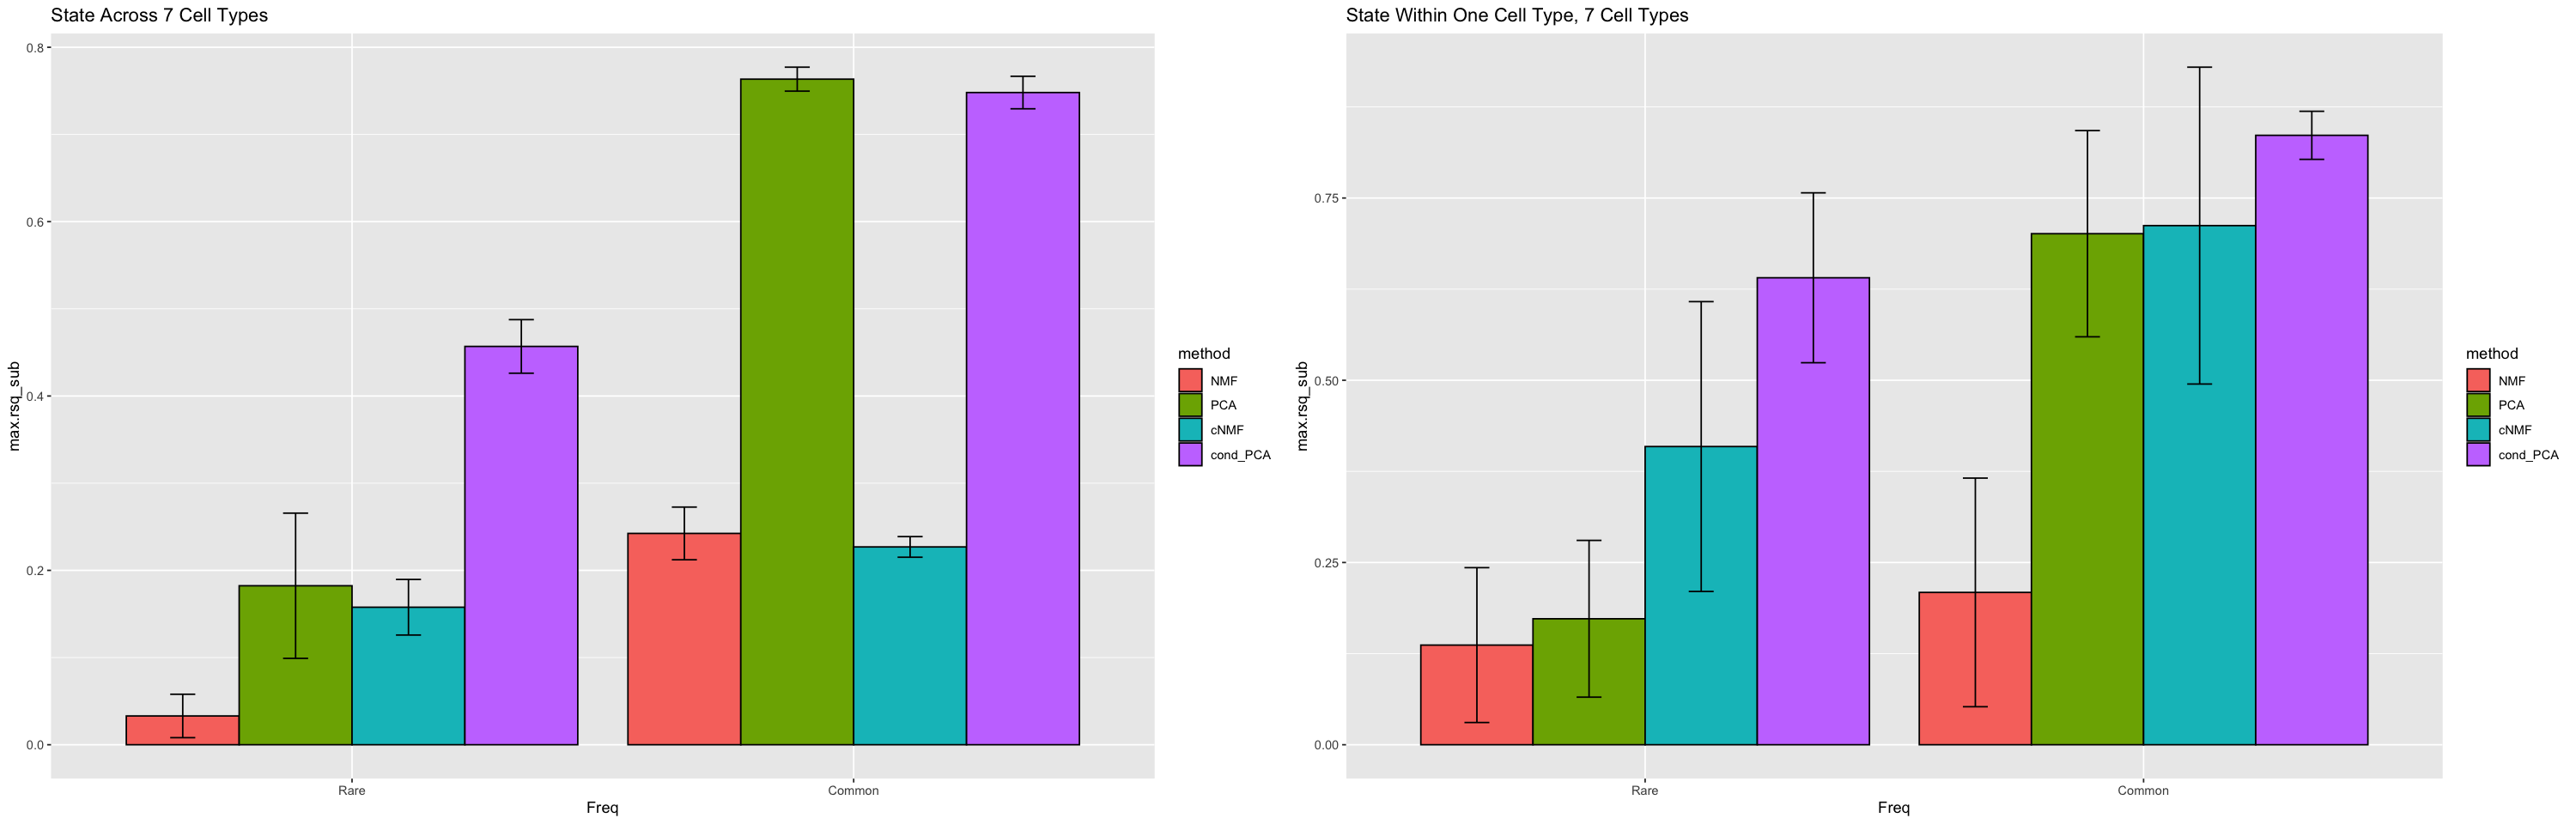

In [14]:


pd = 0.2

type = "across_cts"
ct = "7_cts"

tmp_df = all[(all$flag == ct & all$state_type == type),]

tmp_df$Freq = factor(tmp_df$Freq, levels = c("Rare", "Common"))
# a=ggplot(tmp_df, aes(x=Freq, y=max.rsq_sub, group=method, color=method)) + 
#   geom_line(aes(group = method), position=position_dodge(width=pd),linetype = "dashed") +
#   geom_point(size = 4, position=position_dodge(width=pd))+
#   geom_errorbar(aes(ymin=max.rsq_sub-conf_int_max.rsq_sub, ymax=max.rsq_sub+conf_int_max.rsq_sub), width=.1,
#                  position=position_dodge(pd))+theme_classic()+ ggtitle("State Across 7 Cell Types")


a=ggplot(data=tmp_df, aes(x=Freq, y=max.rsq_sub, fill=method)) +
         geom_bar(stat="identity", color="black", position=position_dodge()) +
  geom_errorbar(aes(ymin=max.rsq_sub-conf_int_max.rsq_sub, ymax=max.rsq_sub+conf_int_max.rsq_sub), width=.2,
                 position=position_dodge(0.9)) + ggtitle("State Across 7 Cell Types")

type = "within_one_ct"
ct = "7_cts"

tmp_df = all[(all$flag == ct & all$state_type == type),]

tmp_df$Freq = factor(tmp_df$Freq, levels = c("Rare", "Common"))
# b = ggplot(tmp_df, aes(x=Freq, y=max.rsq_sub, group=method, color=method)) + 
#   geom_line(aes(group = method), position=position_dodge(width=pd),linetype = "dashed") +
#   geom_point(size = 4, position=position_dodge(width=pd))+
#   geom_errorbar(aes(ymin=max.rsq_sub-conf_int_max.rsq_sub, ymax=max.rsq_sub+conf_int_max.rsq_sub), width=.1,
#                  position=position_dodge(pd))+theme_classic() + ggtitle("State Within One Cell Type, 7 Cell Types")

b=ggplot(data=tmp_df, aes(x=Freq, y=max.rsq_sub, fill=method)) +
         geom_bar(stat="identity", color="black", position=position_dodge()) +
  geom_errorbar(aes(ymin=max.rsq_sub-conf_int_max.rsq_sub, ymax=max.rsq_sub+conf_int_max.rsq_sub), width=.2,
                 position=position_dodge(0.9)) + ggtitle("State Within One Cell Type, 7 Cell Types")

grid.arrange(a, b, ncol=2)

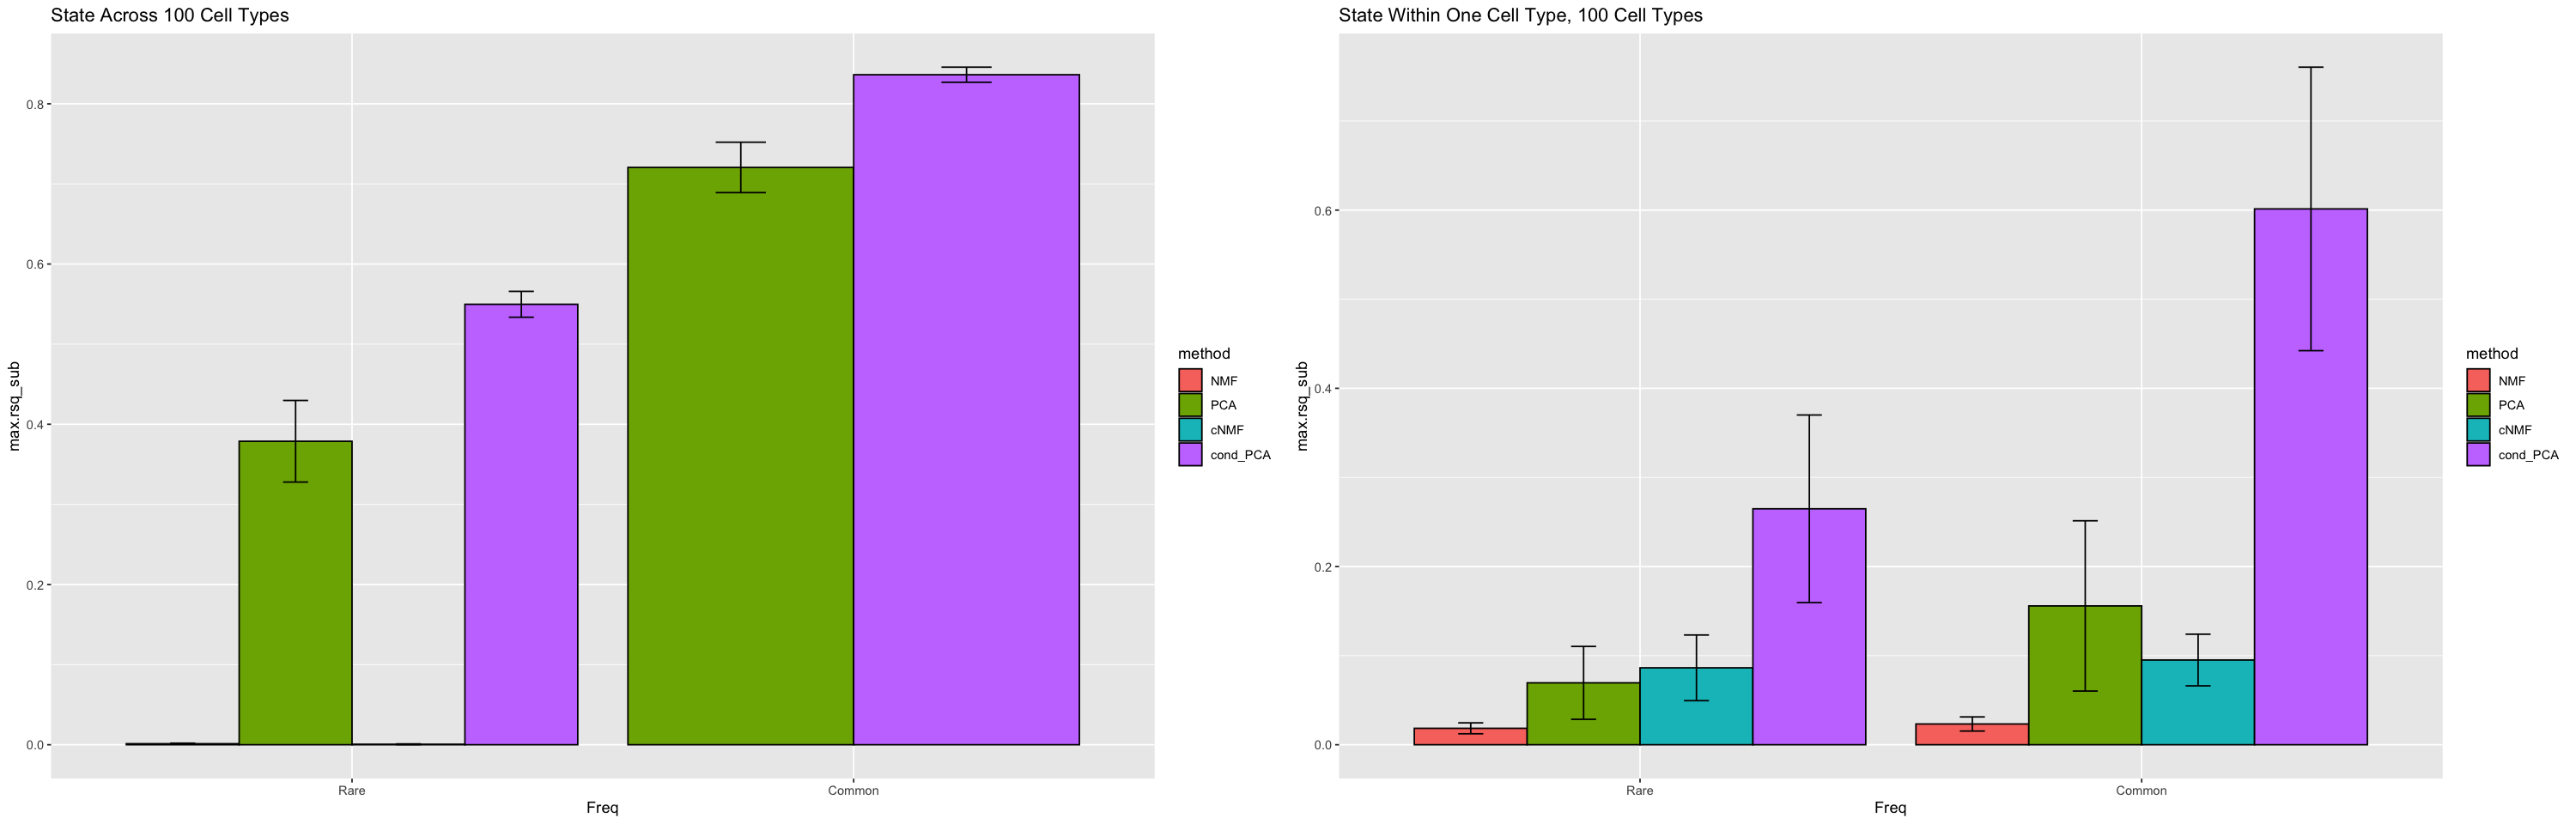

In [15]:
type = "across_cts"
ct = "cts_100"

tmp_df = all[(all$flag == ct & all$state_type == type),]

tmp_df$Freq = factor(tmp_df$Freq, levels = c("Rare", "Common"))
# a = ggplot(tmp_df, aes(x=Freq, y=max.rsq_sub, group=method, color=method)) + 
#   geom_line(aes(group = method), position=position_dodge(width=pd),linetype = "dashed") +
#   geom_point(size = 4, position=position_dodge(width=pd))+
#   geom_errorbar(aes(ymin=max.rsq_sub-conf_int_max.rsq_sub, ymax=max.rsq_sub+conf_int_max.rsq_sub), width=.1,
#                  position=position_dodge(pd))+theme_classic()+ ggtitle("State Across 100 Cell Types")

a=ggplot(data=tmp_df, aes(x=Freq, y=max.rsq_sub, fill=method)) +
         geom_bar(stat="identity", color="black", position=position_dodge()) +
  geom_errorbar(aes(ymin=max.rsq_sub-conf_int_max.rsq_sub, ymax=max.rsq_sub+conf_int_max.rsq_sub), width=.2,
                 position=position_dodge(0.9)) + ggtitle("State Across 100 Cell Types")

type = "within_one_ct"
ct = "cts_100"

tmp_df = all[(all$flag == ct & all$state_type == type),]

tmp_df$Freq = factor(tmp_df$Freq, levels = c("Rare", "Common"))
# b = ggplot(tmp_df, aes(x=Freq, y=max.rsq_sub, group=method, color=method)) + 
#   geom_line(aes(group = method), position=position_dodge(width=pd),linetype = "dashed") +
#   geom_point(size = 4, position=position_dodge(width=pd))+
#   geom_errorbar(aes(ymin=max.rsq_sub-conf_int_max.rsq_sub, ymax=max.rsq_sub+conf_int_max.rsq_sub), width=.1,
#                  position=position_dodge(pd))+theme_classic()+ ggtitle("State Within One Cell Type, 100 Cell Types")

b=ggplot(data=tmp_df, aes(x=Freq, y=max.rsq_sub, fill=method)) +
         geom_bar(stat="identity", color="black", position=position_dodge()) +
  geom_errorbar(aes(ymin=max.rsq_sub-conf_int_max.rsq_sub, ymax=max.rsq_sub+conf_int_max.rsq_sub), width=.2,
                 position=position_dodge(0.9)) + ggtitle("State Within One Cell Type, 100 Cell Types")

grid.arrange(a, b, ncol=2)